In [68]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
import glob
import os
import torch
import pandas as pd
import numpy as np
import multiprocessing 

In [2]:
def get_file_names(s):
    path = './image_data/{}_v2/{}'.format(s, s)
    vals = []
    for root, dirs, files in os.walk(path):
        for filename in files:
            vals.append(filename)
    return sorted(vals)

In [3]:
def display_img(s, filename):
    path = './image_data/{}_v2/{}/{}'.format(s, s, filename)
    plt.imshow(mpimg.imread(path))
    plt.show()

In [4]:
def get_labels(s):
    path = './image_data/written_name_{}_v2.csv'.format(s)
    df = pd.read_csv(path)
    return df

In [5]:
def get_filepath(s, img_name):
    return './image_data/{}_v2/{}/{}'.format(s, s, img_name)

In [20]:
def standard_path(s, filename):
    './image_data{}_v2/{}'.format(s, filename)

In [6]:
train_list_of_files = get_file_names('train')

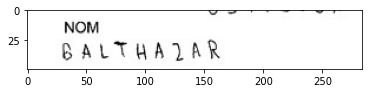

In [7]:
display_img('train', train_list_of_files[0])

Every image has a name in hand written text. Images like these consist in three forms. One as the training set, another as the testing set and finally a validation set. 

In [8]:
test_list_of_files = get_file_names('test')
valid_list_of_files = get_file_names('validation')

Next step is to get a list of the labels for each image.

In [9]:
train_labels = get_labels('train')
test_labels = get_labels('test')
valid_labels = get_labels('validation')
train_labels.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [10]:
# Need to make sure that each image is unique and have no duplicates. 
# Also need to make sure the number of labels equals the number of jpg images
len(train_labels.FILENAME.unique()) == len(train_list_of_files)
len(test_labels.FILENAME.unique()) == len(test_list_of_files)
len(valid_labels.FILENAME.unique()) == len(valid_list_of_files)

True

The data appears to have no duplicates and so every label is associated with one image only. This data seems to be in working order.

# EDA. Checking for important features

In [31]:
from tensorflow.keras.preprocessing import image
import sys
import numpy as np
import numpy as np
import skimage.color
from skimage import io
import skimage.viewer

In [13]:
# First thing to check is to see how the images' pixels average values look
def tonp(list_of_images, size=(64, 64)):
    s = ''
    if 'TRAIN' in list_of_images:
        s = 'train'
    elif 'TEST' in list_of_images:
        s = 'test'
    else:
        s = 'validation'
    # for img in list_of_images:
    path = get_filepath(s, list_of_images)
    current_img = image.load_img(path, target_size=size, color_mode='grayscale')
    # makes a matrix
    img_ts = image.img_to_array(current_img)
    # converts to a vector
    img_ts = [img_ts.ravel()]
    current_img.close()
    try:
        # Brings all the new vectors into one giant array
        full_mat = np.concatenate((full_mat, img_ts))
    except UnboundLocalError:
        full_mat = img_ts
    return list(full_mat)

In [37]:
def get_mean_img(data):
    # Creates a multiprocessing pool to speed up iteration
    a_pool = multiprocessing.Pool()
    # returns a list of numpy array with the values of pixels for each image
    result = a_pool.map(tonp, data)
    # Returns the mean of each image in a (1, 4096) vector
    res = np.mean(result, axis=0)
    # reshape the image back into a matrix
    mean_img = np.array(res).reshape((64, 64))
    # Displays what the average image looks like
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title('Image of {} Mean Pixel Values')
    plt.axis('off')
    plt.grid(True)
    plt.show()
    return mean_img

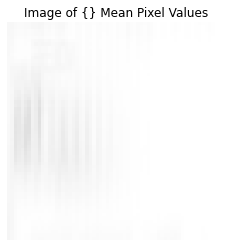

In [51]:
# The images for the training data appear to averagely have their 
# handwritten texts towards the left side of the image.
train_mean_img = get_mean_img(train_list_of_files)

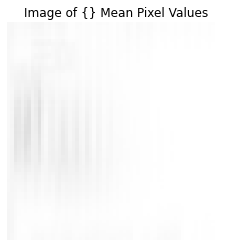

In [41]:
# The images for the testing data appear to averagely have their 
# handwritten texts towards the left side of the image.
test_mean_img = get_mean_img(test_list_of_files)

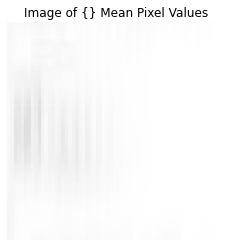

In [42]:
# The images for the validation data appear to averagely have their 
# handwritten texts towards the left side of the image.
valid_mean_img = get_mean_img(valid_list_of_files)

In [56]:
data = Image.fromarray(train_mean_img)

In [57]:
type(data)

PIL.Image.Image

In [58]:
# I will check the mean distribution of pixels on each of the datasets

imageio.core.util.Array

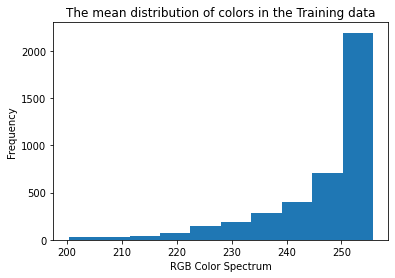

In [62]:
# I will check the mean distribution of pixels on each of the datasets
plt.hist(train_mean_img.ravel())
plt.title('The mean distribution of colors in the Training data')
plt.xlabel('RGB Color Spectrum')
plt.ylabel('Frequency')
plt.show()

The distribution appears to show that there is a negatively skewed dataset. There are mostly values lumped up near the white color spectrum. There appears to be a lot of white in the images and a lot less color from the text. I will have to minimize this to make it easier for the neural net.

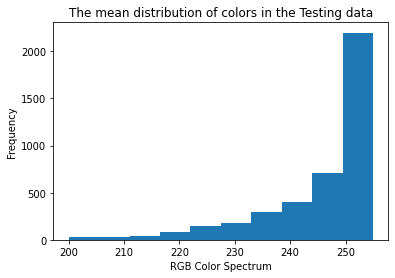

In [63]:
plt.hist(test_mean_img.ravel())
plt.title('The mean distribution of colors in the Testing data')
plt.xlabel('RGB Color Spectrum')
plt.ylabel('Frequency')
plt.show()

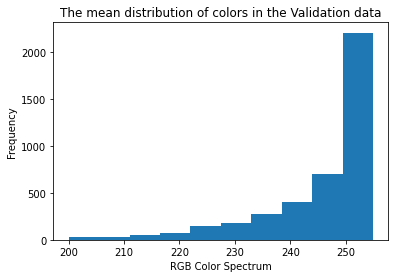

In [65]:
plt.hist(valid_mean_img.ravel())
plt.title('The mean distribution of colors in the Validation data')
plt.xlabel('RGB Color Spectrum')
plt.ylabel('Frequency')
plt.show()

The same problems appear in the mean's of the testing and validation set. Too many white pixels in the image. This can cause the neural net to run longer if kept.

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


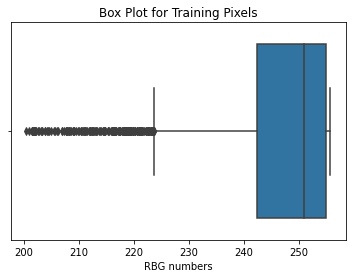

In [73]:
sns.boxplot(train_mean_img.ravel())
plt.xlabel('RBG numbers')
plt.title('Box Plot for Training Pixels')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


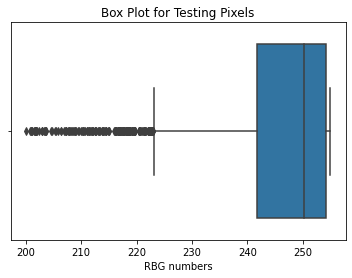

In [75]:
sns.boxplot(test_mean_img.ravel())
plt.xlabel('RBG numbers')
plt.title('Box Plot for Testing Pixels')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


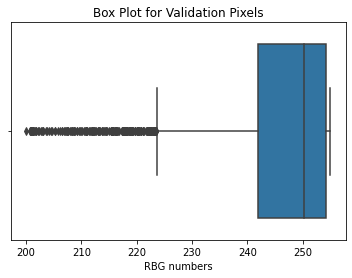

In [76]:
sns.boxplot(valid_mean_img.ravel())
plt.xlabel('RBG numbers')
plt.title('Box Plot for Validation Pixels')
plt.show()